<a href="https://www.kaggle.com/code/jetty2307/some-teams-comparison?scriptVersionId=104101551" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.options.mode.chained_assignment = None  

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/international-football-results-from-1872-to-2017/shootouts.csv
/kaggle/input/international-football-results-from-1872-to-2017/results.csv


In the data set, we can see basically all results of international games between national teams. We would like to analyze historical performance of several teams. It's well known that often a team's performance on its own ground is different from its performance in away games. So we should properly distinguish between home and away games, as well as games on the neutral field.

We want to check if the host team representation is correct in the data. First, let's try to catch the most obvious violation of it - when the "away" team actually played in a home country.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
foot = pd.read_csv('/kaggle/input/international-football-results-from-1872-to-2017/results.csv', parse_dates=['date'])

it = "Italy"
de = "Germany"
br = "Brazil"
ag = "Argentina"

foot[foot["away_team"] == foot["country"]]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
788,1924-03-13,Catalonia,Spain,0,7,Friendly,Barcelona,Spain,False
1618,1933-10-04,Silesia,Poland,1,2,Friendly,Katowice,Poland,False
1650,1934-02-02,Catalonia,Spain,0,2,Friendly,Barcelona,Spain,False
2756,1947-10-19,Catalonia,Spain,3,1,Friendly,Barcelona,Spain,False
3489,1953-04-26,Silesia,Poland,2,3,Friendly,Chorzów,Poland,False
3529,1953-08-09,Catalonia,Spain,0,6,Friendly,Barcelona,Spain,False
3542,1953-09-13,Silesia,Poland,3,3,Friendly,Byton,Poland,False
29036,2006-12-09,Silesia,Poland,1,1,Friendly,Chorzów,Poland,False


It turns out that this violation can happen in two possible cases. In the first case, we can observe it, when a country plays against a part of the country itself. For example, here we can see that Catalonia plays against Spain in Barcelona. The game is marked as an away game for Spain (3rd column), played in Spain (8th column), not on a neutral field (9th column). Despite the possible confusion, the entire note is basically correct, as in this case, the field in Barcelona can indeed be considered more a 'home' field for Catalonia than for Spain. The same situation applies to the games between Silesia and Poland played in Silesian region of Poland. So we should not change anything in this case.

In the second case, games are played between two explicitly different countries - e.g. between Peru and Brazil (last row). The game was played in San Paolo, Brazil, but it is marked as a neutral game for both teams (apparently, because Brazil hosted the tournament - and all games therein were marked as neutral). I think, one can reach a consensus that such a game should be defined as a home game for Brazil. Then we should swap home and away teams, home and away scores, and change the "neutral" feature to False

In [3]:
idx = (foot["away_team"] == foot["country"]) & (~foot["away_team"].isin(['Spain', 'Poland']))
foot.loc[idx.astype(bool),['home_score','away_score']] = foot.loc[idx.astype(bool),['away_score','home_score']].values
foot.loc[idx.astype(bool),['home_team','away_team']] = foot.loc[idx.astype(bool),['away_team','home_team']].values
foot.loc[idx.astype(bool),['neutral']] = False

foot[foot["away_team"] == foot["country"]]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
788,1924-03-13,Catalonia,Spain,0.0,7.0,Friendly,Barcelona,Spain,False
1618,1933-10-04,Silesia,Poland,1.0,2.0,Friendly,Katowice,Poland,False
1650,1934-02-02,Catalonia,Spain,0.0,2.0,Friendly,Barcelona,Spain,False
2756,1947-10-19,Catalonia,Spain,3.0,1.0,Friendly,Barcelona,Spain,False
3489,1953-04-26,Silesia,Poland,2.0,3.0,Friendly,Chorzów,Poland,False
3529,1953-08-09,Catalonia,Spain,0.0,6.0,Friendly,Barcelona,Spain,False
3542,1953-09-13,Silesia,Poland,3.0,3.0,Friendly,Byton,Poland,False
29036,2006-12-09,Silesia,Poland,1.0,1.0,Friendly,Chorzów,Poland,False


Another possible case of violation is when values of the fields "home_team" and "country" coincide, but the "neutral" value is True. This must be changed. 

In [4]:
foot[(foot["home_team"] == foot["country"]) & (foot["neutral"] == True)].head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral


In [5]:
idx = (foot["home_team"] == foot["country"]) & (foot["neutral"] == True)
foot.loc[idx.astype(bool),['neutral']] = False

Now we want to make a comparison of historical performances of two most successful European national teams - Italy and Germany, and two most successful South American teams - Brazil and Argentina. For representation, let's assign 1 point to the team in case of win, 0 points in case of draw and -1 point in case of loss. To avoid too frequent fluctuations, we will calculate the team's performance as a rolling mean over the last 20 games which corresponds on average to 1,5-2 years in modern era.

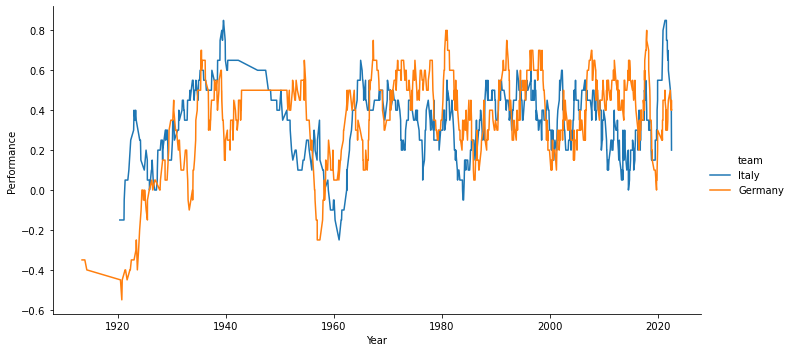

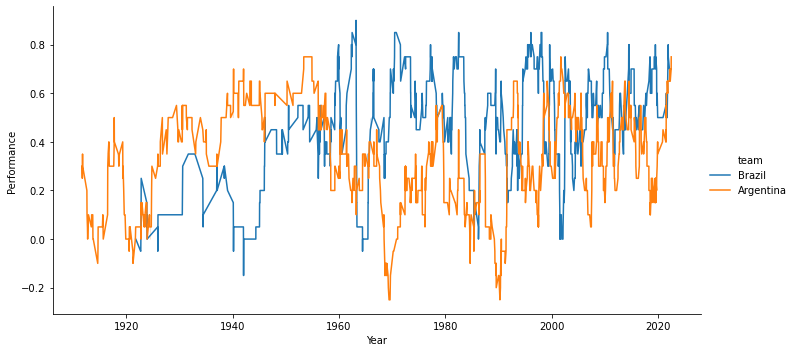

In [6]:
from matplotlib.dates import DateFormatter


#function which defines the games results from data and assigns the points and outcomes
def performance(team):
    en_foot = foot[(foot["home_team"] == team) | (foot["away_team"] == team)] 
    en_foot["team"] = team       
    conditions = [
        (en_foot["home_score"] == en_foot["away_score"]),
        ((en_foot["home_score"] > en_foot["away_score"]) & (en_foot["home_team"] == team)),
        ((en_foot["home_score"] < en_foot["away_score"]) & (en_foot["away_team"] == team)),
        ((en_foot["home_score"] < en_foot["away_score"]) & (en_foot["home_team"] == team)),
        ((en_foot["home_score"] > en_foot["away_score"]) & (en_foot["away_team"] == team))
        ]       
    values = [0, 1, 1, -1, -1]    
    values_w = ["Draws","Wins", "Wins", "Losses", "Losses"]
    en_foot['result'] = np.select(conditions, values)
    en_foot['result_w'] = np.select(conditions, values_w)
    en_foot['result_20games'] = en_foot.result.rolling(20).mean()    
    return en_foot 

date_form = DateFormatter("%y")

countries = ["Italy","Germany","Brazil","Argentina"]
set_t = [performance(item) for item in countries]

concatenated = pd.concat([set_t[0].assign(dataset='set_t[0]'), set_t[1].assign(dataset='set_t[1]')])
concatenated1 = pd.concat([set_t[2].assign(dataset='set_t[2]'), set_t[3].assign(dataset='set_t[3]')])

fig1 = sns.relplot(x="date", y="result_20games", kind='line', aspect=2, data=concatenated, hue = "team")
fig2 = sns.relplot(x="date", y="result_20games", kind='line', aspect=2, data=concatenated1, hue = "team")

sns.color_palette("husl", 8)
fig1.set_axis_labels('Year', 'Performance')
fig2.set_axis_labels('Year', 'Performance')

On the plots, we can catch best team eras - for example a famous Vittorio Pozzo's Italian team dominating in 30s, as well as their recent record winning streak with Roberto Mancini. Germany shows very good performance around 1980 (European Cup victory) and following the last World Cup trophy in 2014. Before the WWII Italy in general overperformed Germany, after the war, the teams swapped the leadership from one period to another.

Argentina in general overperformed Brazil before the first World Cup trophy of the latter in 1958. Then mostly Brazil dominated. Particularly, the contribution of golden squads from 1958-1962 and 1970 is visible. Argentina was especially good in 40s and 50s due to the Copa America titles, and also in the end of 90s - although without titles. 

Let's create the pie charts of results of national teams which we analyzed

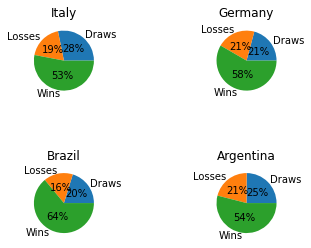

In [7]:
data = [item.groupby("result_w")["result_w"].count() for item in set_t]
labels = [item.keys() for item in data]

pie, ax = plt.subplots(2,2)
plt.subplots_adjust(hspace = 0.9)
subplots = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
i = 0
for pl in subplots:    
    pl.set(title=countries[i])       
    pl.pie(x=data[i], autopct="%.0f%%", labels=labels[i], pctdistance=0.5)    
    i = i+1 


Now let's check a famous hypothesis which states that alpine countries in South America, like Bolivia and Ecuador benefit from their high altitude while playing home games, while other teams struggle playing there. It is indeed interesting to clarify to which extent this is true.

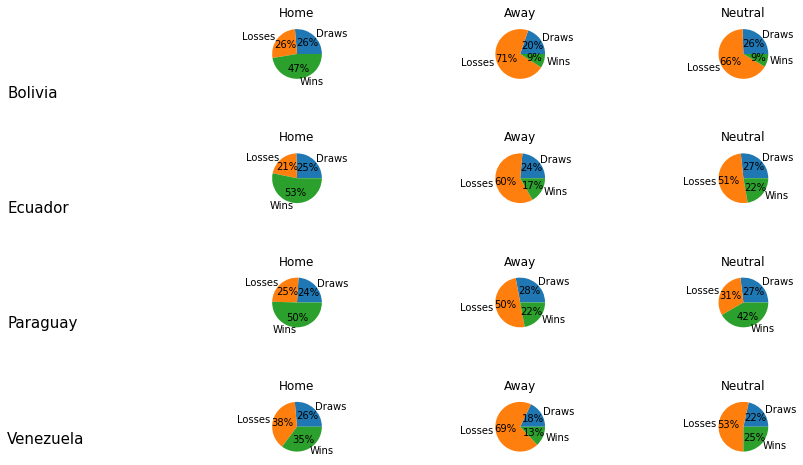

In [8]:
conmebol = ["Bolivia", "Ecuador", "Paraguay", "Venezuela"]
pie, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))
plt.subplots_adjust(hspace = 1.0, wspace = 1.0)
figsize=(8, 6)
i = 0
y = 0.75

for team in conmebol:
    home_performance = performance(team)[performance(team).country == team]
    away_performance = performance(team)[(performance(team).country != team) & (performance(team).neutral == False)]
    neutral_performance = performance(team)[performance(team).neutral == True]
    
    data1 = home_performance.groupby("result_w")["result_w"].count()
    labels1 = data1.keys()
    data2 = away_performance.groupby("result_w")["result_w"].count()
    labels2 = data2.keys()
    data3 = neutral_performance.groupby("result_w")["result_w"].count()
    labels3 = data3.keys()
    
    pie.text(-0.2, y-.2*i, f'{team}', fontsize=15)
    ax[i,0].pie(x=data1, autopct="%.0f%%", labels=labels1)
    ax[i,0].set_title("Home")
    ax[i,1].pie(x=data2, autopct="%.0f%%", labels=labels2)
    ax[i,1].set_title("Away")
    ax[i,2].pie(x=data3, autopct="%.0f%%", labels=labels3)
    ax[i,2].set_title("Neutral")
    
    i = i + 1

It turns out that Bolivia indeed performs much better at the home ground, having won about 5-6 times more frequently than in away games or games on the neutral field. Ecuador's ratio is rather about 3-4.

We can compare performances of Ecuador and Bolivia with performances of comparable teams from CONMEBOL - such as Paraguay and Venezuela. This preserves the similarity of sets of opponents for all teams, as most often teams from the same continental confederation play against each other.

Although, Paraguay and Venezuela also play better at home, the difference is not that striking, especially compared to the games on the neutral field.